In [20]:
import pandas as pd
from tqdm import tqdm

from tokenizer.charylutokenizer import CharyluTokenizer

In [21]:
df = pd.read_parquet(
    "/media/luis/BIGGER/datasets/nlp_datasets/metadata/all_metadata_nodup_lang.pq"
)
df = df[df.duplicado_80 == 0].reset_index(drop=True)
df = df[df.lang.isin(["pt", "en", "fr", "it", "es"])].reset_index(drop=True)
df = df[df.tipo != "code"].reset_index(drop=True)
df

,txt_len,limpeza_cc,partition_ref,partition_index,base,lang,duplicado_80,duplicado_90,duplicado_95,duplicado_98,tipo
0,467526,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,0,livros,pt,0,0,0,0,pdf
1,52364,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,1,livros,pt,0,0,0,0,pdf
2,389677,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,2,livros,pt,0,0,0,0,pdf
3,913546,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,3,livros,pt,0,0,0,0,pdf
4,564605,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,4,livros,pt,0,0,0,0,pdf
...,...,...,...,...,...,...,...,...,...,...,...
46687113,221909,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,995,pdfs_dominio_publico,pt,0,0,0,0,pdf
46687114,506,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,996,pdfs_dominio_publico,pt,0,0,0,0,pdf
46687115,133266,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,997,pdfs_dominio_publico,en,0,0,0,0,pdf
46687116,1344,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,998,pdfs_dominio_publico,pt,0,0,0,0,pdf


In [22]:
import numpy as np

amostra = []

for base in tqdm(df.base.unique()):
    df_base = df[df.base == base].reset_index(drop=True)
    particoes = list(df_base.partition_ref.unique())
    ps = np.random.choice(particoes, min(len(particoes), 10))
    for p in ps:
        filtered = df_base[df_base.partition_ref == p]
        amostra.append(filtered.sample(min(100, len(filtered))))

amostra = pd.concat(amostra).reset_index(drop=True)
amostra = amostra.drop_duplicates().reset_index(drop=True)
df = None
amostra.base.value_counts()

100%|██████████| 14/14 [00:41<00:00,  2.98s/it]


base
wikipedia_pt                1000
commom_crawl                1000
cc100                       1000
wikipedia_en                1000
sentencas                   1000
blogset_br                  1000
dkyoon_slimpajama_6b        1000
open_orca_slimorca_dedup     999
itd_stj                      999
cshorten_ml_arxiv_papers     994
pdfs_dominio_publico         986
alpaca                       300
pdfs_tjsp                    110
livros                        80
Name: count, dtype: int64

In [23]:
from pathlib import Path
from tqdm import tqdm

tokenizers = [
    "/home/luis/projetos/luis_transformers/artifacts/charylu_nocode/tokenizer_2024_32k.json",
    "/home/luis/projetos/luis_transformers/artifacts/charylu_nocode/tokenizer_2024_50k.json",
    "/home/luis/projetos/luis_transformers/artifacts/charylu_nocode/tokenizer_2024_60k.json",
    "/home/luis/projetos/luis_transformers/artifacts/charylu_nocode/tokenizer_2024_70k.json",
    "/home/luis/projetos/luis_transformers/artifacts/charylu_nocode/tokenizer_2024_80k.json",
    "/home/luis/projetos/luis_transformers/artifacts/charylu_nocode/tokenizer_2024_90k.json",
    "/home/luis/projetos/luis_transformers/artifacts/charylu_nocode/tokenizer_2024_100k.json",
    "/home/luis/projetos/luis_transformers/artifacts/charylu_nocode/tokenizer_2024_110k.json",
    "/home/luis/projetos/luis_transformers/artifacts/charylu_nocode/tokenizer_2024_120k.json",
    "/home/luis/projetos/luis_transformers/artifacts/charylu_nocode/tokenizer_2024_130k.json",
    "/home/luis/projetos/luis_transformers/artifacts/charylu_nocode/tokenizer_2024_150k.json",
]

num_tokenizers = len(tokenizers)
tokenizers = {Path(t).stem: CharyluTokenizer(tokenizer_path=t) for t in tokenizers}

tokens_tokenizers = {t:[] for t in tokenizers.keys()}

amosta = amostra.sort_values("partition_ref").reset_index(drop=True)
particao_atual = None
nome_particao_atual = None
textos = []
for _, row in tqdm(amostra.iterrows(), total=len(amostra)):
    particao = row.partition_ref
    linha_particao = row.partition_index

    if particao_atual is None or nome_particao_atual != particao:
        # precisa recarregar a particao
        particao_atual = pd.read_parquet(particao)
        nome_particao_atual = particao

    texto = particao_atual.loc[linha_particao, "text"]
    if len(texto) > 40_000:
        texto = texto[:40_000]
    textos.append(texto)

for tokenizer_name, tokenizer in tokenizers.items():
    for texto in tqdm(textos):
        tokens = tokenizer.tokenize(texto)
        tokens_tokenizers[tokenizer_name].append(len(tokens))


100%|██████████| 11468/11468 [00:35<00:00, 322.66it/s]


In [39]:
import re
tamanhos = []
contagem = 0
for t in textos:
    palavras = re.sub(r"\n[\n]+?", " ", t).split(" ")
    tamanhos += [len(p) for p in palavras]
    contagem += 1

    if contagem >= 1000:
        break

for p in range(0, 100, 5):
    print(f"{p} - {np.percentile(tamanhos, p)}")

0 - 0.0
5 - 1.0
10 - 1.0
15 - 2.0
20 - 2.0
25 - 2.0
30 - 2.0
35 - 3.0
40 - 3.0
45 - 4.0
50 - 5.0
55 - 5.0
60 - 6.0
65 - 7.0
70 - 7.0
75 - 8.0
80 - 8.0
85 - 9.0
90 - 10.0
95 - 12.0


In [40]:
print(textos[80])

Explique como a inteligência artificial pode ser usada para moldar o futuro do marketing

A inteligência artificial (IA) já está sendo usada para moldar o futuro do marketing, ajudando os profissionais de marketing a entender melhor seus clientes e personalizar seus serviços, a fim de aumentar os níveis de engajamento com os clientes. As tecnologias baseadas em IA podem ser usadas para coletar e analisar grandes quantidades de dados do cliente, tomar decisões mais inteligentes e automatizar tarefas repetitivas no processo de marketing. A IA também pode fornecer insights poderosos sobre comportamentos e preferências do cliente, que podem ser usados para criar mensagens mais eficazes, segmentação aprimorada do cliente e até mesmo criar modelos preditivos que o comportamento futuro.


In [41]:
for tokenizer_name in tokens_tokenizers.keys():
    amostra[tokenizer_name] = tokens_tokenizers[tokenizer_name]

amostra

,txt_len,limpeza_cc,partition_ref,partition_index,base,lang,duplicado_80,duplicado_90,duplicado_95,duplicado_98,...,tokenizer_2024_50k,tokenizer_2024_60k,tokenizer_2024_70k,tokenizer_2024_80k,tokenizer_2024_90k,tokenizer_2024_100k,tokenizer_2024_110k,tokenizer_2024_120k,tokenizer_2024_130k,tokenizer_2024_150k
0,68825,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,4,livros,pt,0,0,0,0,...,10596,10322,10162,10036,9959,9885,9815,9775,9740,9663
1,1111092,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,2,livros,pt,0,0,0,0,...,11333,11101,10914,10765,10651,10538,10466,10404,10341,10223
2,1042951,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,1,livros,pt,0,0,0,0,...,11962,11651,11476,11332,11201,11096,11027,10962,10877,10776
3,105001,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,0,livros,pt,0,0,0,0,...,11764,11572,11419,11265,11157,11024,10969,10896,10846,10783
4,61824,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,5,livros,pt,0,0,0,0,...,10281,10077,9916,9796,9666,9601,9541,9494,9446,9353
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11463,85809,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,696,pdfs_dominio_publico,pt,0,0,0,0,...,13377,13174,12972,12814,12655,12571,12483,12428,12372,12276
11464,389755,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,969,pdfs_dominio_publico,pt,0,0,0,0,...,10872,10647,10505,10383,10263,10194,10130,10076,10037,9964
11465,151963,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,27,pdfs_dominio_publico,pt,0,0,0,0,...,9813,9658,9519,9406,9329,9261,9214,9183,9153,9083
11466,1529,1,/media/luis/BIGGER/datasets/nlp_datasets/parti...,496,pdfs_dominio_publico,pt,0,0,0,0,...,461,454,444,435,430,423,419,418,414,411


In [42]:
primeiro = None
for tokenizer_name in tokens_tokenizers.keys():
    if primeiro is None:
        primeiro = amostra.groupby(["lang", "base"])[tokenizer_name].describe()
    print(tokenizer_name)
    print(amostra.groupby(["lang", "base"])[tokenizer_name].describe() / primeiro)

tokenizer_2024_32k
                               count  mean  std  min  25%  50%  75%  max
lang base                                                               
en   commom_crawl                1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
     cshorten_ml_arxiv_papers    1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
     dkyoon_slimpajama_6b        1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
     open_orca_slimorca_dedup    1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
     pdfs_dominio_publico        1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
     wikipedia_en                1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
es   commom_crawl                1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
     pdfs_dominio_publico        1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
fr   pdfs_dominio_publico        1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
it   pdfs_dominio_publico        1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
pt   alpaca                      1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
     blogset_br                 

In [43]:
primeiro = None
for tokenizer_name in tokens_tokenizers.keys():
    if primeiro is None:
        primeiro = amostra.groupby(["lang"])[tokenizer_name].describe()
    print(tokenizer_name)
    print(amostra.groupby(["lang"])[tokenizer_name].describe() / primeiro)

tokenizer_2024_32k
      count  mean  std  min  25%  50%  75%  max
lang                                           
en      1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
es      1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
fr      1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
it      1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
pt      1.0   1.0  1.0  1.0  1.0  1.0  1.0  1.0
tokenizer_2024_50k
      count      mean       std       min       25%       50%       75%  \
lang                                                                      
en      1.0  0.937061  0.955623  0.938776  0.928854  0.920482  0.923036   
es      1.0  0.940851  0.944971  0.917910  0.952563  0.924385  0.944132   
fr      1.0  0.948607  0.956244  0.971660  0.949979  0.933648  0.938843   
it      1.0  0.934644  0.939424  0.916804  0.928761  0.935263  0.937443   
pt      1.0  0.945789  0.949292  0.983871  0.936567  0.941176  0.944503   

           max  
lang            
en    0.995401  
es    0.956178  
fr    0.965358  
it    0.939330 

In [44]:
import numpy as np
dados = {
    "base": [],
    "tokenizer": [],
    "lang": [],
    "p": [],
    "value": []
}

dados_lang = {
    "lang": [],
    "p": [],
    "value": [],
    "tokenizer": []
}
for base in amostra.base.unique():
    local = amostra[amostra.base == base].reset_index(drop=True)

    for tokenizer_name in tokens_tokenizers.keys():
        tipo_tokenizer = tokenizer_name.split("_")[-1]
        # print(tokenizer_name)
        # percentis = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
        # for p in percentis:
        #     valor = np.percentile(local[tokenizer_name].tolist(), int(p*100))
        valor = np.sum(local[tokenizer_name].tolist())
        p = 1
        dados["base"].append(base)
        dados["tokenizer"].append(tokenizer_name)
        dados["lang"].append(local.loc[0, "lang"])
        dados["value"].append(valor)
        dados["p"].append(int(100*p))

        # media = np.mean(tokens_tokenizers[tokenizer_name])
        # print(media)
        # minimo = np.min(tokens_tokenizers[tokenizer_name])
        # print(minimo)
        # maximo = np.max(tokens_tokenizers[tokenizer_name])
        # print(maximo)
        # print("\n")
            
for lang in amostra.lang.unique():
    local = amostra[amostra.lang == lang].reset_index(drop=True)
    for tokenizer_name in tokens_tokenizers.keys():
        tipo_tokenizer = tokenizer_name.split("_")[-1]
        # percentis = [0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.99]
        # for p in percentis:
        #     valor = np.percentile(local[tokenizer_name].tolist(), int(p*100))
        
        valor = np.sum(local[tokenizer_name].tolist())
        p = 1
        dados_lang["tokenizer"].append(tokenizer_name)
        dados_lang["lang"].append(local.loc[0, "lang"])
        dados_lang["value"].append(valor)
        dados_lang["p"].append(int(100*p))

In [45]:
for k in dados.keys():
    print(len(dados[k]))

154
154
154
154
154


In [46]:
dados_df_base = pd.DataFrame(dados)
dados_df_lang = pd.DataFrame(dados_lang)
dados_df_lang

,lang,p,value,tokenizer
0,pt,100,17807232,tokenizer_2024_32k
1,pt,100,16841882,tokenizer_2024_50k
2,pt,100,16533942,tokenizer_2024_60k
3,pt,100,16305027,tokenizer_2024_70k
4,pt,100,16135298,tokenizer_2024_80k
5,pt,100,15992520,tokenizer_2024_90k
6,pt,100,15876366,tokenizer_2024_100k
7,pt,100,15776378,tokenizer_2024_110k
8,pt,100,15693960,tokenizer_2024_120k
9,pt,100,15624828,tokenizer_2024_130k


In [47]:
# normaliza pelo maior
normalizada_base = []
for base in dados_df_base.base.unique():
    for p in dados_df_base.p.unique():
        local = dados_df_base[(dados_df_base.base == base) & (dados_df_base.p == p)]
        local.value  = local.value / local.value.max()
        normalizada_base.append(local)
normalizada_base = pd.concat(normalizada_base).reset_index(drop=True)

normalizada_lang = []
for lang in dados_df_lang.lang.unique():
    for p in dados_df_lang.p.unique():
        local = dados_df_lang[(dados_df_lang.lang == lang) & (dados_df_lang.p == p)]
        local.value  = local.value / local.value.max()
        normalizada_lang.append(local)
normalizada_lang = pd.concat(normalizada_lang).reset_index(drop=True)
normalizada_lang

/tmp/ipykernel_881982/1386765431.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

/tmp/ipykernel_881982/1386765431.py:14: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,lang,p,value,tokenizer
0,pt,100,1.000000,tokenizer_2024_32k
1,pt,100,0.945789,tokenizer_2024_50k
2,pt,100,0.928496,tokenizer_2024_60k
3,pt,100,0.915641,tokenizer_2024_70k
4,pt,100,0.906109,tokenizer_2024_80k
5,pt,100,0.898091,tokenizer_2024_90k
6,pt,100,0.891568,tokenizer_2024_100k
7,pt,100,0.885953,tokenizer_2024_110k
8,pt,100,0.881325,tokenizer_2024_120k
9,pt,100,0.877443,tokenizer_2024_130k


In [48]:
normalizada_base["tokenizer_size"] = normalizada_base.tokenizer.apply(lambda x: int(x.split("_")[-1].replace("k", "")))
normalizada_lang["tokenizer_size"] = normalizada_lang.tokenizer.apply(lambda x: int(x.split("_")[-1].replace("k", "")))

In [49]:
pt_base = pd.pivot_table(data=normalizada_base[normalizada_base.p.isin([100, 20, 50, 90, 99])], values="value", index=["base", "tokenizer_size", "lang"], columns="p")
pt_base

p                                      100
base         tokenizer_size lang          
alpaca       32             pt    1.000000
             50             pt    0.940111
             60             pt    0.917653
             70             pt    0.905268
             80             pt    0.894644
...                                    ...
wikipedia_pt 100            pt    0.872328
             110            pt    0.866262
             120            pt    0.860776
             130            pt    0.856311
             150            pt    0.848716

[154 rows x 1 columns]

In [50]:
pt_lang = pd.pivot_table(data=normalizada_lang[normalizada_lang.p.isin([20, 50, 90, 99, 100])], values="value", index=["lang", "tokenizer_size"], columns="p")
pt_lang

p                         100
lang tokenizer_size          
en   32              1.000000
     50              0.937061
     60              0.917330
     70              0.902500
     80              0.890420
     90              0.881276
     100             0.873657
     110             0.867015
     120             0.861458
     130             0.856412
     150             0.848415
es   32              1.000000
     50              0.940851
     60              0.921411
     70              0.906684
     80              0.895442
     90              0.885148
     100             0.876340
     110             0.867799
     120             0.862139
     130             0.855739
     150             0.846412
fr   32              1.000000
     50              0.948607
     60              0.929316
     70              0.913670
     80              0.902259
     90              0.893463
     100             0.885253
     110             0.876776
     120             0.871901
     130             0.865632
     150             0.857397
it   32              1.000000
     50              0.934644
     60              0.910161
     70              0.890141
     80              0.872344
     90              0.860042
     100             0.851451
     110             0.843019
     120             0.834765
     130             0.827087
     150             0.813972
pt   32              1.000000
     50              0.945789
     60              0.928496
     70              0.915641
     80              0.906109
     90              0.898091
     100             0.891568
     110             0.885953
     120             0.881325
     130             0.877443
     150             0.870892

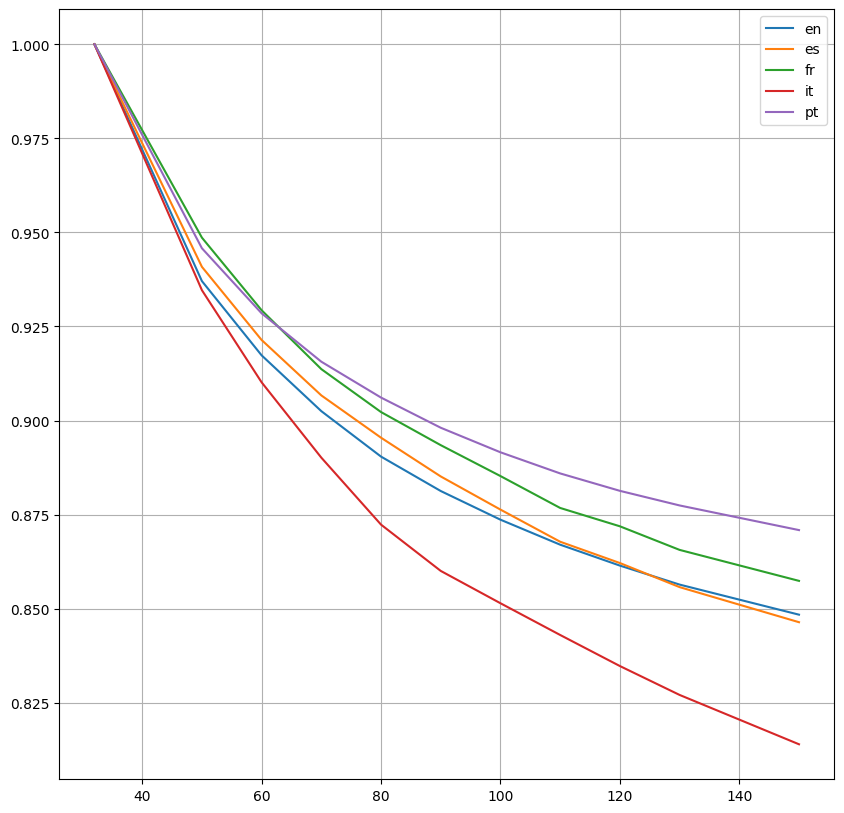

In [51]:
num_tokenizers = len(tokenizers)

import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(10, 10)

for i in range(0, len(pt_lang), num_tokenizers):
    indexes = [ind[1] for ind in pt_lang.iloc[i:i + num_tokenizers].index]
    bases = [ind[0] for ind in pt_lang.iloc[i:i + num_tokenizers].index]
    ax.plot(indexes, pt_lang.iloc[i:i + num_tokenizers][100].values, label=bases[0])
ax.grid()
ax.legend()

In [52]:
num_tokenizers = len(tokenizers)

import plotly.graph_objects as go

fig = go.Figure()

for i in range(0, len(pt_lang), num_tokenizers):
    indexes = [ind[1] for ind in pt_lang.iloc[i:i + num_tokenizers].index]
    bases = [ind[0] for ind in pt_lang.iloc[i:i + num_tokenizers].index]
    fig.add_trace(
        go.Scatter(
            x = indexes,
            y = pt_lang.iloc[i:i + num_tokenizers][100].values,
            name = bases[0],
        )
    )
fig.update_layout(
    height=1000
)
fig.show()

In [53]:
import plotly.graph_objects as go

cores_langs = {
    "pt": "green",
    "en": "red",
    "it": "blue",
    "fr": "blue",
    "es": "blue"
}

dashes_bases = {
    "the_stack_v1_html": "dot",
    "the_stack_v1_markdown": "dot",
    "the_stack_v1_shell": "dot",
    "the_stack_v1_python": "dot",
    "ajibawa_2023_Code_290k_ShareGPT": "dot",
    "the_stack_v1_powershell": "dot",
    "the_stack_v1_sql": "dot",
    "vikp_textbook_quality_programming": "dot",
    "cc100":"dash",
    "dkyoon_slimpajama_6b":"dash",
    "wikipedia_en":"dash",
    "wikipedia_pt":"dash",
    "commom_crawl":"dash",
    "blogset_br":"dash",
    "cshorten_ml_arxiv_papers":"dash",
    "sentencas": "dashdot",
    "itd_stj": "dashdot",
    "pdfs_tjsp": "dashdot",
    "pdfs_dominio_publico": "dashdot",
    "livros": "dashdot",
    "open_orca_slimorca_dedup": "dot",
    "alpaca": "dot",
}

fig = go.Figure()

for i in range(0, len(pt_base), num_tokenizers):
    indexes = [ind[1] for ind in pt_base.iloc[i:i + num_tokenizers].index]
    bases = [ind[0] for ind in pt_base.iloc[i:i + num_tokenizers].index]
    langs = [ind[2] for ind in pt_base.iloc[i: i + num_tokenizers].index]
    fig.add_trace(
        go.Scatter(
            x = indexes,
            y = pt_base.iloc[i:i + num_tokenizers][100].values,
            name = bases[0],
            line=dict(color=cores_langs[langs[0]], dash=dashes_bases[bases[0]])
        )
    )
fig.update_layout(
    height=1000
)
fig.show()


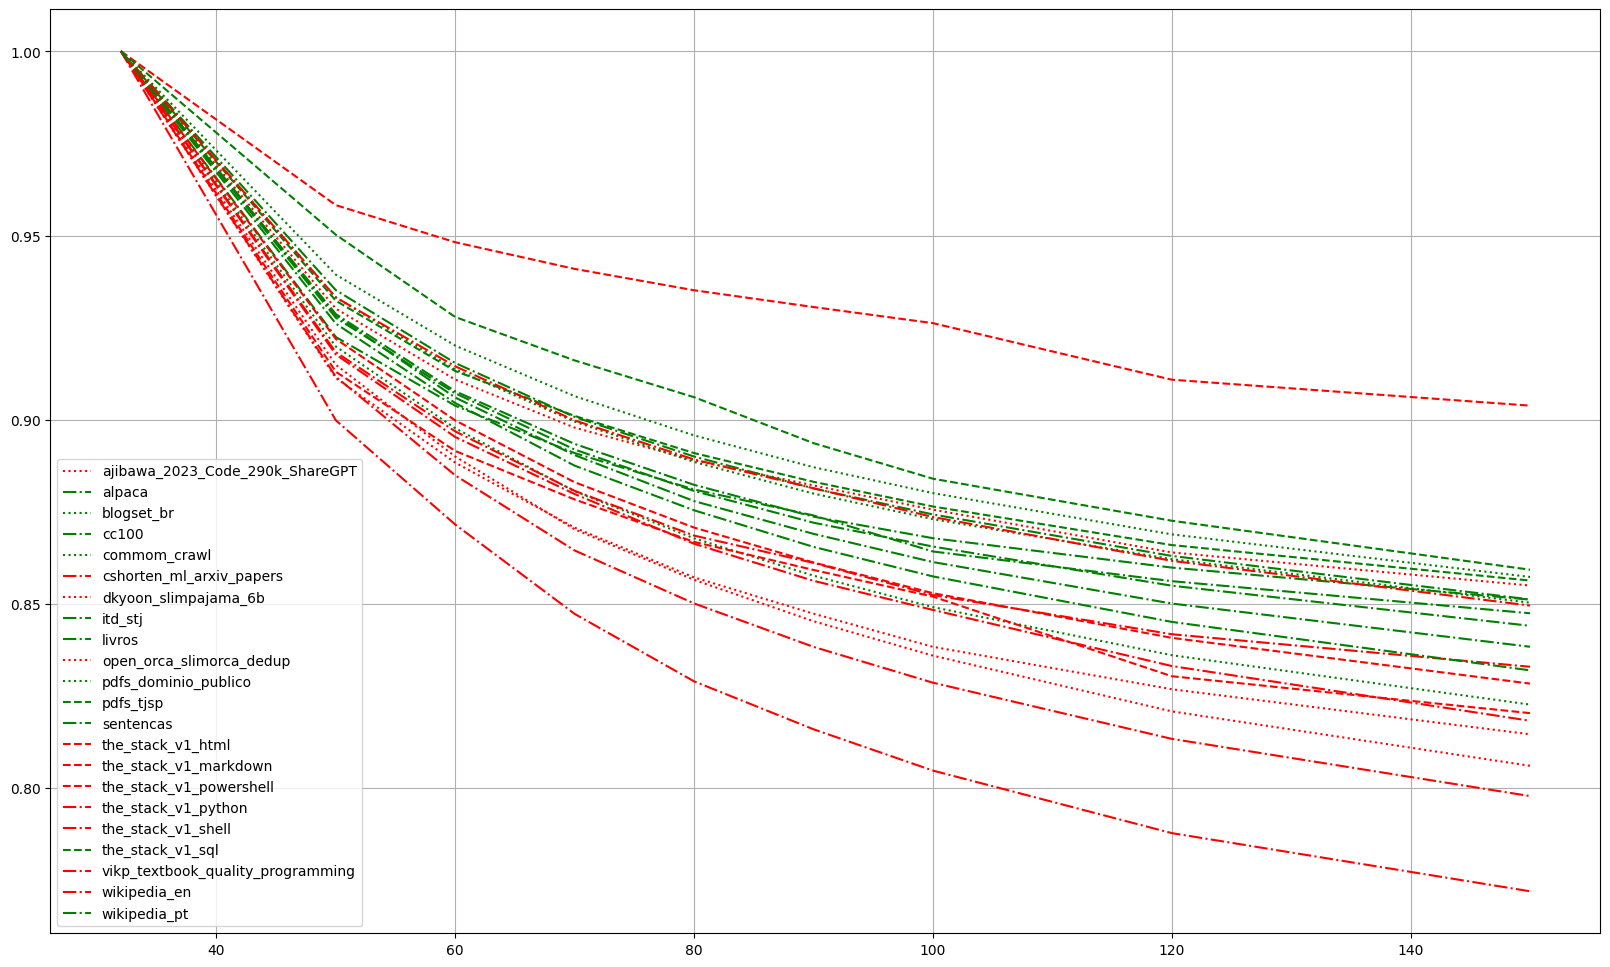

In [20]:
import matplotlib.pyplot as plt
import numpy as np

cores_langs = {
    "pt": "green",
    "en": "red",
    "it": "blue",
    "fr": "black",
    "es": "yellow"
}

fig, ax = plt.subplots()
fig.set_size_inches(20, 12)

for i in range(0, len(pt_base), num_tokenizers):
    indexes = [ind[1] for ind in pt_base.iloc[i:i + num_tokenizers].index]
    bases = [ind[0] for ind in pt_base.iloc[i:i + num_tokenizers].index]
    langs = [ind[2] for ind in pt_base.iloc[i: i + num_tokenizers].index]
    ax.plot(indexes, pt_base.iloc[i:i + num_tokenizers][100].values, label=bases[0], linestyle=np.random.choice(["-.", "--", "-.", ":"]), color=cores_langs[langs[0]])
ax.grid()
ax.legend()

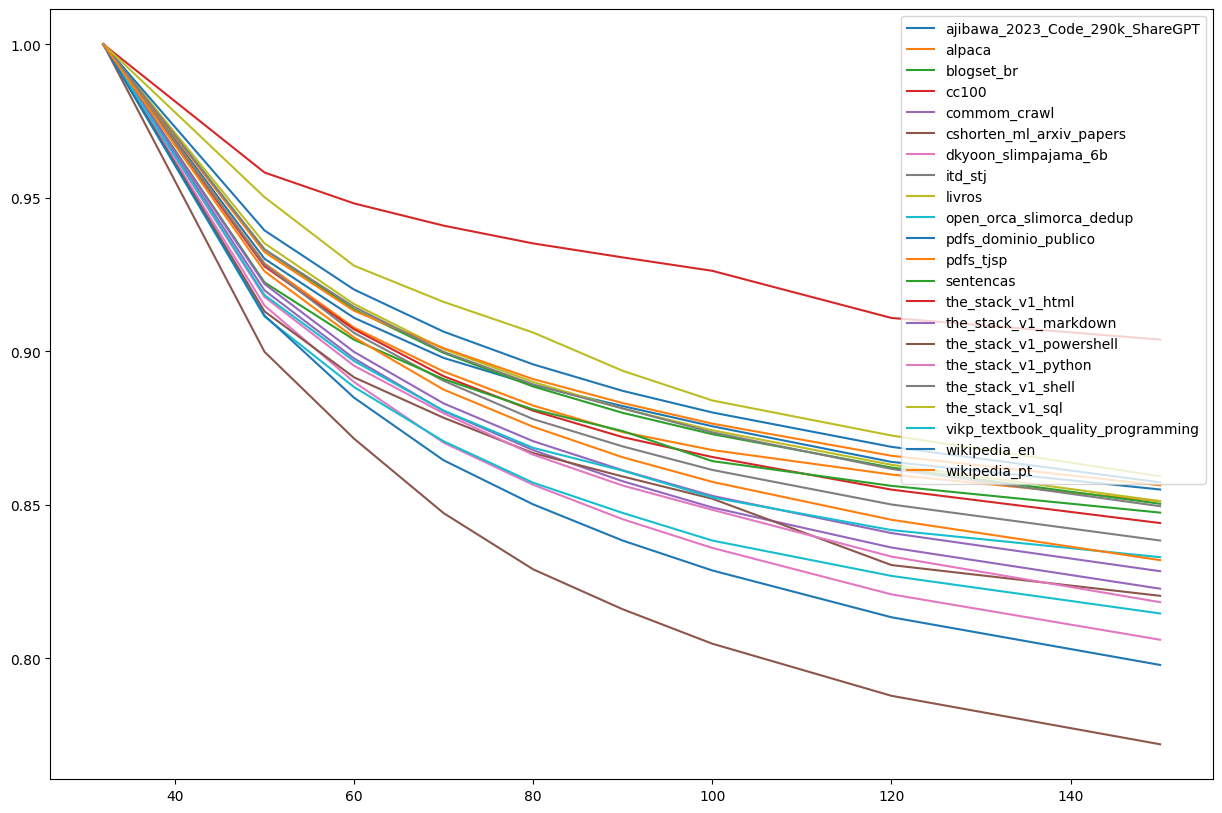

In [21]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)

for i in range(0, len(pt_base), num_tokenizers):
    indexes = [ind[1] for ind in pt_base.iloc[i:i + num_tokenizers].index]
    bases = [ind[0] for ind in pt_base.iloc[i:i + num_tokenizers].index]
    ax.plot(indexes, pt_base.iloc[i:i + num_tokenizers][100].values, label=bases[0])
ax.legend()